In [1]:
import numpy as np
import numpy.fft as fft
import matplotlib.pyplot as plt
import scipy.signal as sig
import mat73 as matload

import bmfrm.bmfrm2d as bmfrm2d
import bmfrm.trigengines as trig

In [2]:
# Material parameters
c = 1540        # assumed speed of sound in medium [m/s]

# Transducer parameters
dele = 0.298E-3 # element spacing [meters]
nele = 128      # number of elements
fc = 5.208E6    # center frequency [Hz]
lam = c/fc      # wavelength [m]

# Acquisition parameters
fs = 20.833E6   # sampling frequency [Hz]
nacq = 128      # number of acquisitions
tstart = 5 * lam / c    # sample starting point [seconds]
foctx = 28E-3   # focal depth of transmits
focrx = 30E-3   # focal depth of receives

# Reconstruction parameters
dx = 0.298E-3   # beam spacing of pixels [m]
dz = lam/8      # axial spacing of pixels [m]
zmin = 2E-3;    # starting depth for reconstruction
zmax = 60E-3;   # end depth of recon
nz = int(np.round((zmax-zmin)/dz))   # number of samples
usf = 10        # axial upsampling factor [newsamp/oldsamp]

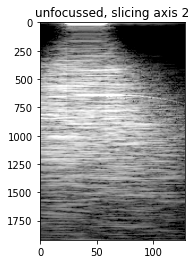

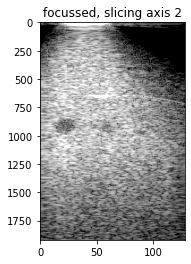

In [3]:
# filepw = "/datacommons/ultrasound/wew12/classes/unfocused_transmit1.mat"
# filefoc = "/datacommons/ultrasound/wew12/classes/focused_transmit1.mat"
filepw = "C:\\Users\\14142\\OneDrive - Duke University\\Classes\\RIP\\Ultrasound\\unfocused_transmit1.mat"
filefoc = "C:\\Users\\14142\\OneDrive - Duke University\\Classes\\RIP\\Ultrasound\\focused_transmit1.mat"

datapw = matload.loadmat(filepw)['rf']
datapw = datapw.transpose(0, 1, 2)
datafoc = matload.loadmat(filefoc)['rf']

env = np.abs(sig.hilbert(datapw[:,:,40], axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))
plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, aspect=0.1, cmap='gray')
plt.title('unfocussed, slicing axis 2')
plt.show()

env = np.abs(sig.hilbert(datafoc[:,:,40], axis=0))
logged = 20*np.log10(env/np.percentile(env, 99))
plt.figure()
plt.imshow(logged, vmin=-40, vmax=0, aspect=0.1, cmap='gray')
plt.title('focussed, slicing axis 2')
plt.show()

In [4]:
def calctabs(c:float, fnum:float, ref:np.array, focus:np.array, eles:np.array):
    """Calculate the delay tabs to generate a given focal point
    
    Parameters:
    ----
    `c`: speed of sound [m/s]
    `fnum`: fnumer of transmition apperature [m/m]
    `ref`: reference point for a given focus
    `focus`: focus point in the field
    `eles` : location of elements relative to field

    Returns:
    ----
    `tau_ele`: delay tabs by element
    """
    if (np.ndim(focus) < 1): raise Exception("ref must be a vector of length 3")
    if (np.ndim(focus) > 2): raise Exception("ref must be a vector of length 3")
    if (not np.prod(focus.shape) == 3): raise Exception("ref must be a vector of length 3")
    if (np.ndim(ref) < 1): raise Exception("ref must be a vector of length 3")
    if (np.ndim(ref) > 2): raise Exception("ref must be a vector of length 3")

    # calcualte which elements are in the apperature
    ref = ref.reshape((1, 3))
    focus = focus.reshape((1, 3))
    r = np.sqrt(np.sum((eles - ref)**2, axis = 1))
    mask = focus[0,2] / fnum >= 2 * r
    
    # calculate the distance from every element to the focus point
    dist = np.sqrt(np.sum((eles-focus)**2, axis=1))
    tau_ele = dist / c

    # correct the tabs by the earliest tab inside of the appereature
    tau_0 = np.max(tau_ele[mask])
    tau_ele = tau_0 - tau_ele
    
    return tau_ele

In [5]:
# Define reconstruction grid (space)
x = dx * (np.arange(nacq) - (nacq-1)/2)
y = 0
z = dz * np.arange(nz) + zmin
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')
field = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

# define element locations (space)
x = dele * (np.arange(nele) - (nele-1)/2)
y = 0
z = 0
X, Y, Z = np.meshgrid(x, y, z, indexing='xy')
eles = np.array([X.flatten(), Y.flatten(), Z.flatten()]).T

# define rf trace time vector
nt = datafoc.shape[0]
t = tstart + np.arange(nt)/fs

# postprocessing 
usf = int(8)

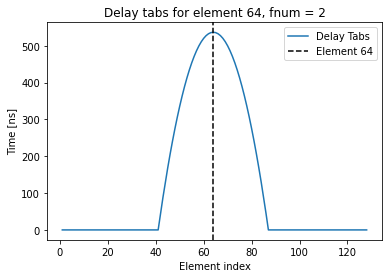

In [6]:
# Verify delay tab calculations are working
ind = 64
dt, mask = trig.dtbyele(c=c, fnum=2, focus = np.array([[(ind-1-(nele-1)/2)*dele, 0, 28E-3]]), eles=eles)
dt[~mask] = 0
plt.figure()
plt.plot(1+np.arange(nele), 1E9*dt, label='Delay Tabs')
plt.title(f'Delay tabs for element {ind}, fnum = 2')
plt.axvline(x=ind, color='k', linestyle='--', label=f'Element {ind}')
plt.ylabel('Time [ns]')
plt.xlabel('Element index')
plt.legend()
plt.show()

In [7]:
# Upsample data
from scipy.signal import resample
datafoc, t = resample(datafoc, nt*usf, t, axis=0)
datapw = resample(datapw, nt*usf, axis=0)
Ts = np.mean(np.diff(t)) # the upsampled sampling period
nt = len(t)

In [8]:
# generate an image from focus data
alines_foc = []
alines_pw = []
fnum=2

# for each acquisition
image = []
summed = 0
for indacq in np.arange(nacq):
    ## Process the plane wave image
    # extract the reconstructed points for this image
    indstart = indacq*nz
    indstop = (indacq+1)*nz
    subfield = field[indstart:indstop,:]

    # generate the transmit delay tabs for this element
    tau_tx = trig.pwtxengine(c=c, tref=0, theta=0, phi=0, ref=eles[indacq,:], points=subfield)
    focus = np.array([[dx*(indacq-(nacq-1)/2), 0, foctx]])

    # for each receive element...
    dns = []
    for indele in range(nele):
        tau_rx = trig.rxengine(c=c, ref=eles[indele,:], points=subfield)
        tau = tau_tx + tau_rx - tstart
        t_ind = np.round(tau/Ts).astype(int)

        mask = trig.genmask(fnum=2, ref=eles[indacq,:], focus=focus, points=subfield, dynamic=False)

        rf = datafoc[:,indele,indacq]
        dns.append(rf[t_ind]*mask)
    dns = np.array(dns).T
    summed = summed + dns
image = np.array(summed)

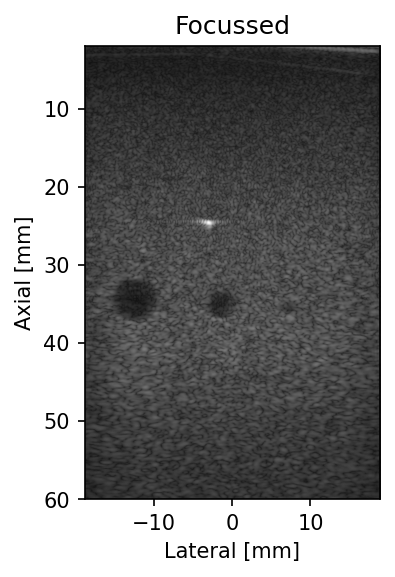

In [9]:

image_pw = np.array(image)
extent = 1E3*np.array([np.min(x), np.max(x), zmax, zmin])
image_pw_us = sig.resample(image_pw, usf*image_pw.shape[0], axis = 0)
image_pw_us = sig.resample(image_pw_us, usf*image_pw.shape[1], axis = 1)
env = np.abs(sig.hilbert(image_pw_us, axis=0))
comp = 0.3
logged = np.exp(comp*np.log(env/np.max(env)))

plt.figure(dpi=150)
plt.imshow(logged, vmin=0, vmax=1, cmap='gray', extent=extent)
plt.ylabel('Axial [mm]')
plt.xlabel('Lateral [mm]')
plt.title("Focussed")
plt.show()

In [10]:
# generate an image from focus data
alines_foc = []
alines_pw = []
fnum=2

# for each acquisition
image = []
summed = 0
for indacq in np.arange(nacq):
    ## Process the plane wave image
    # extract the reconstructed points for this image
    indstart = indacq*nz
    indstop = (indacq+1)*nz
    subfield = field[indstart:indstop,:]

    # generate the transmit delay tabs for this element
    tau_tx = trig.pwtxengine(c=c, tref=0, theta=0, phi=0, ref=eles[indacq,:], points=subfield)
    tau_tx = subfield[:,2]/c
    focus = np.array([[dx*(indacq-(nacq-1)/2), 0, foctx]])

    # for each receive element...
    dns = []
    for indele in range(nele):
        tau_rx = trig.rxengine(c=c, ref=eles[indele,:], points=subfield)
        tau = tau_tx + tau_rx
        t_ind = np.round(tau/Ts).astype(int)

        mask = trig.genmask(fnum=2, ref=eles[indacq,:], focus=focus, points=subfield, dynamic=False)

        rf = datapw[:,indele,indacq]
        dns.append(rf[t_ind]*mask)
    dns = np.array(dns).T
    summed += dns
image = np.array(summed)

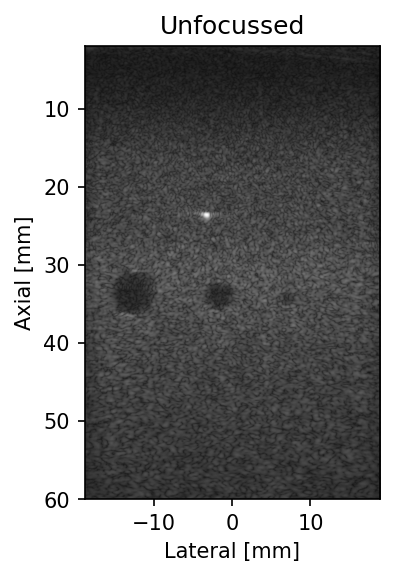

In [11]:

image_pw = np.array(image)
extent = 1E3*np.array([np.min(x), np.max(x), zmax, zmin])
image_pw_us = sig.resample(image_pw, usf*image_pw.shape[0], axis = 0)
image_pw_us = sig.resample(image_pw_us, usf*image_pw.shape[1], axis = 1)
env = np.abs(sig.hilbert(image_pw_us, axis=0))
comp = 0.3
logged = np.exp(comp*np.log(env/np.max(env)))

plt.figure(dpi=150)
plt.imshow(logged, vmin=0, vmax=1, cmap='gray', extent=extent)
plt.ylabel('Axial [mm]')
plt.xlabel('Lateral [mm]')
plt.title("Unfocussed")
plt.show()

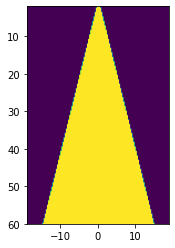

In [12]:
focus = np.array(eles[64,:])
focus[2] = 30E-3
mask = trig.genmask(2, eles[64,:], focus, points = field, dynamic=True)
mask = mask.reshape((nz, -1), order='f')

plt.figure()
plt.imshow(mask, extent=extent)
plt.show()

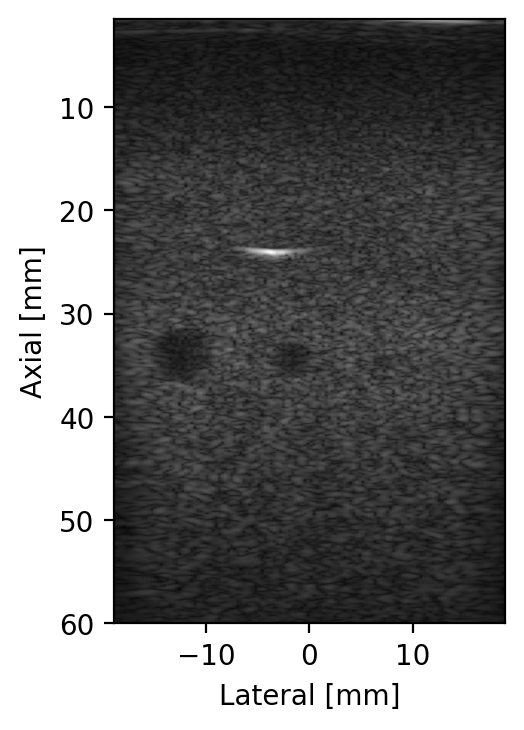

In [13]:
summed = 0
for inda in range(nacq):
    dataacq = np.array(datapw[:,:,inda])

    # calculate the delay tabs for transmit
    focus = np.array(eles[inda])
    focus[2] = 30E-3
    tau_rx = calctabs(c, fnum, eles[inda], focus, eles)
    tabs = np.round((tau_rx-tstart)/Ts).astype(int)
    mask = trig.genmask(2, eles[inda,:], focus, points = eles, dynamic=False)
    mask = mask.reshape((1, -1), order='f')
    for inde in range(nele):
        vec = dataacq[:,inde]
        vec = np.roll(vec, tabs[inde])
        dataacq[:,inde] = vec
    masked = mask*dataacq
    summed += masked[::8,:]

pw_static = summed
comp=0.4
pw_static = sig.resample(pw_static, pw_static.shape[0]*usf, axis=0)
pw_static = sig.resample(pw_static, pw_static.shape[1]*usf, axis=1)
env = np.abs(sig.hilbert(summed, axis=0))
logged = np.exp(comp*np.log(env/np.max(env)))
extent = 1E3*np.array([np.min(x), np.max(x), np.max(t)*c/2, np.min(t)*c/2])
plt.figure(dpi=200)
plt.imshow(logged, vmin=0, vmax=1, cmap='gray', extent=extent)
plt.xlabel("Lateral [mm]")
plt.ylabel("Axial [mm]")
plt.ylim(60, 1.5)
plt.show()

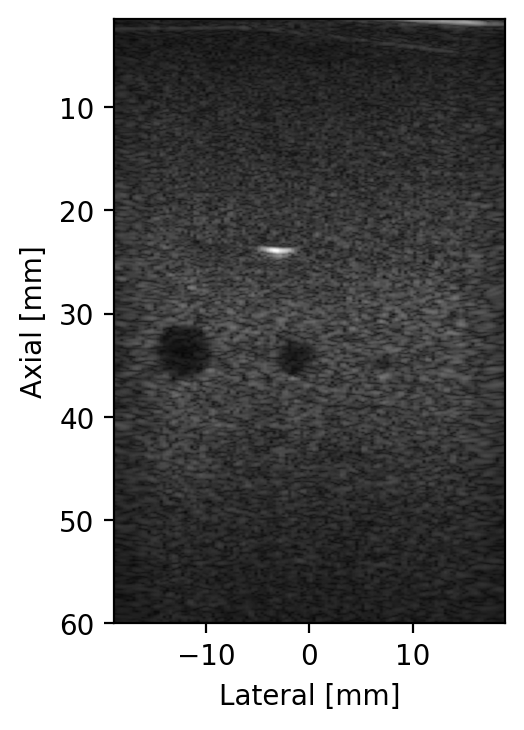

In [14]:
summed = 0
for inda in range(nacq):
    comp = 0.6
    dataacq = np.array(datafoc[:,:,inda])

    # calculate the delay tabs for transmit
    focus = np.array(eles[inda])
    focus[2] = 28E-3
    tau_tx = calctabs(c, fnum, eles[inda], focus, eles)
    focus[2] = 30E-3
    tau_rx = calctabs(c, fnum, eles[inda], focus, eles)
    tabs = np.round((tau_rx - np.max(tau_tx)-tstart)/Ts).astype(int)
    mask = trig.genmask(2, eles[inda,:], focus, points = eles, dynamic=False)
    mask = mask.reshape((1, -1), order='f')
    for inde in range(nele):
        vec = dataacq[:,inde]
        vec = np.roll(vec, tabs[inde])
        dataacq[:,inde] = vec
    masked = mask*dataacq
    summed += masked

foc_static = summed
comp=0.4
env = np.abs(sig.hilbert(summed, axis=0))
logged = np.exp(comp*np.log(env/np.max(env)))
extent = 1E3*np.array([np.min(x), np.max(x), np.max(t)*c/2, np.min(t)*c/2])
plt.figure(dpi=200)
plt.imshow(logged, vmin=0, vmax=1, cmap='gray', extent=extent)
plt.xlabel("Lateral [mm]")
plt.ylabel("Axial [mm]")
plt.ylim(60, 1.5)
plt.show()

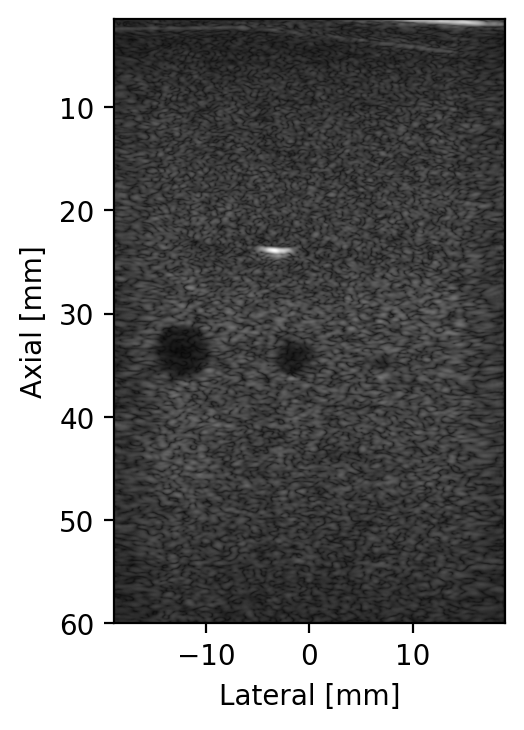

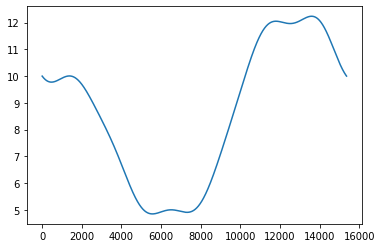

In [37]:
tgc = [10, 10, 9, 7, 5, 5, 5, 7, 10, 12, 12, 12]
TGC = sig.resample(tgc, foc_static.shape[0]).reshape((-1, 1))
foc_tgc = foc_static * TGC
foc_tgc = sig.resample(foc_tgc, foc_tgc.shape[1]*usf, axis=1)
env = np.abs(sig.hilbert(foc_tgc, axis=0))
logged = np.exp(comp*np.log(env/np.max(env)))

plt.figure(dpi=200)
plt.imshow(logged, vmin=0, vmax=1, cmap='gray', extent=extent)
plt.xlabel("Lateral [mm]")
plt.ylabel("Axial [mm]")
plt.ylim(60, 1.5)
plt.show()

plt.figure()
plt.plot(TGC)
plt.show()